  FIFA WORLD CUP 2026 DRAW SIMULATOR
  Predicting Uzbekistan's Group Placement
Running 100,000 simulations...
  Progress: 10,000 / 100,000
  Progress: 20,000 / 100,000
  Progress: 30,000 / 100,000
  Progress: 40,000 / 100,000
  Progress: 50,000 / 100,000
  Progress: 60,000 / 100,000
  Progress: 70,000 / 100,000
  Progress: 80,000 / 100,000
  Progress: 90,000 / 100,000
  Progress: 100,000 / 100,000

FIFA WORLD CUP 2026 DRAW SIMULATION RESULTS
Target Team: Uzbekistan

Simulations: 100,000
Successful:  52,351
Failed:      47,649

------------------------------------------------------------
GROUP PROBABILITIES
------------------------------------------------------------
  Group A:   7.95% ███████████████
  Group B:   7.80% ███████████████
  Group C:   8.60% █████████████████
  Group D:   7.77% ███████████████
  Group E:   8.48% ████████████████
  Group F:   8.41% ████████████████
  Group G:   8.48% ████████████████
  Group H:   8.48% ████████████████
  Group I:   8.52% █████████████████
  

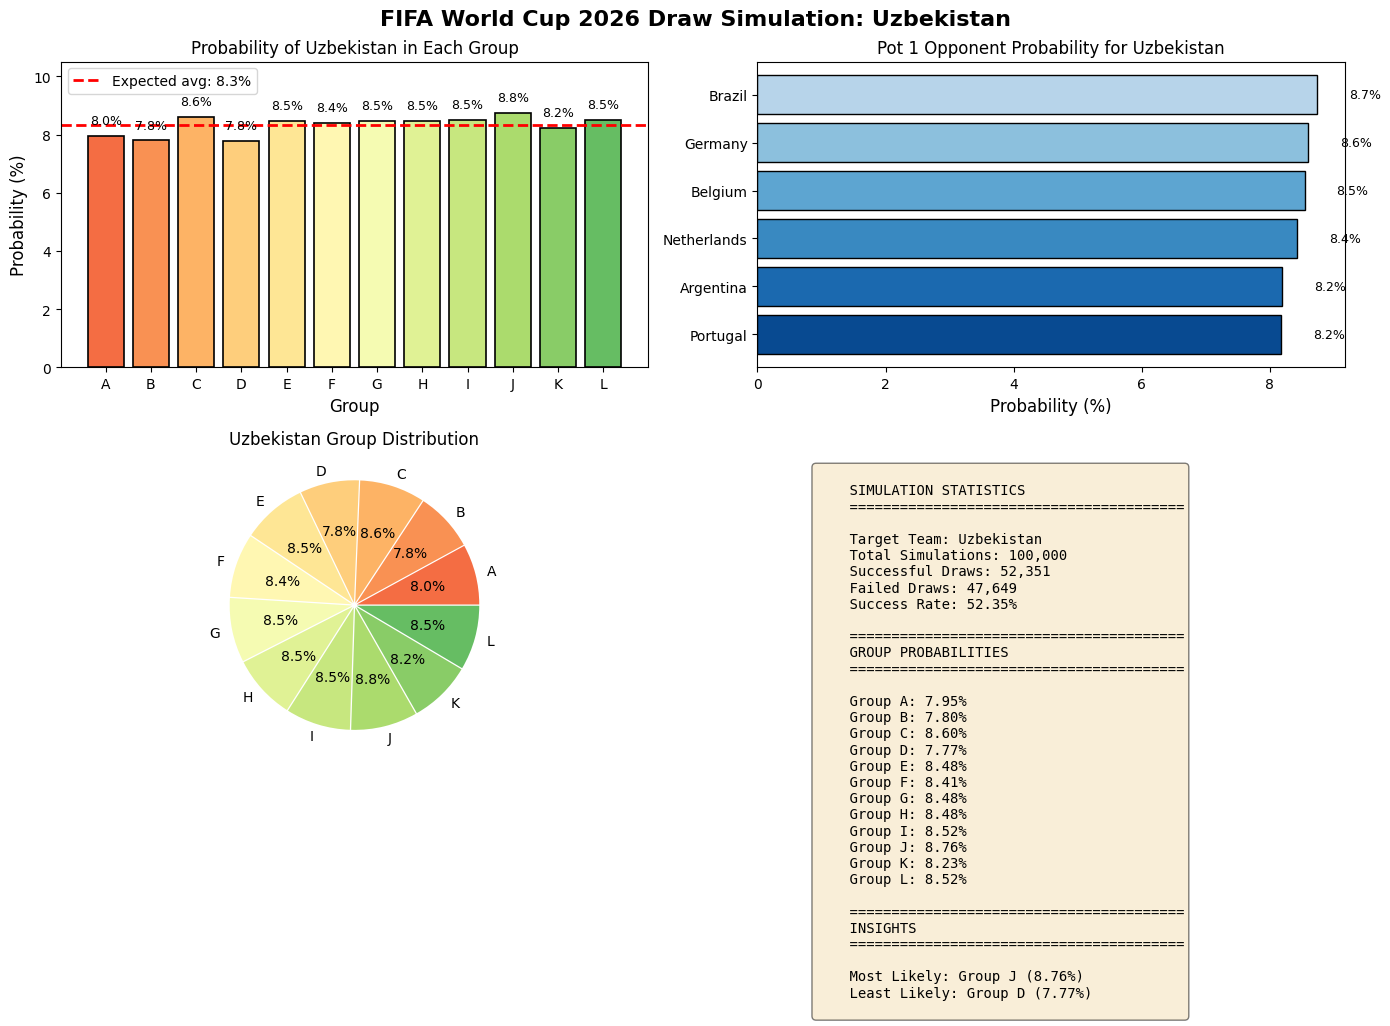


Visualization saved as 'uzbekistan_draw_simulation.png'

Results saved to uzbekistan_draw_simulation_results.json


In [9]:
# FIFA World Cup 2026 Draw Simulator
# Simulates the draw thousands of times to predict group placement probabilities.
# Applies all official FIFA constraints.


import random
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Optional
import json

# Try to import visualization libraries
try:
    import matplotlib.pyplot as plt
    import numpy as np
    HAS_MATPLOTLIB = True
except ImportError:
    HAS_MATPLOTLIB = False
    print("Note: matplotlib not installed. Install with 'pip install matplotlib numpy' for visualizations.")


# =============================================================================
# TEAM DATA - (Team Name, Confederation)
# =============================================================================

POT_1 = [
    ("Canada", "CONCACAF"), ("Mexico", "CONCACAF"), ("USA", "CONCACAF"),
    ("Spain", "UEFA"), ("Argentina", "CONMEBOL"), ("France", "UEFA"),
    ("England", "UEFA"), ("Brazil", "CONMEBOL"), ("Portugal", "UEFA"),
    ("Netherlands", "UEFA"), ("Belgium", "UEFA"), ("Germany", "UEFA")
]

POT_2 = [
    ("Croatia", "UEFA"), ("Morocco", "CAF"), ("Colombia", "CONMEBOL"),
    ("Uruguay", "CONMEBOL"), ("Switzerland", "UEFA"), ("Japan", "AFC"),
    ("Senegal", "CAF"), ("IR Iran", "AFC"), ("Korea Republic", "AFC"),
    ("Ecuador", "CONMEBOL"), ("Austria", "UEFA"), ("Australia", "AFC")
]

POT_3 = [
    ("Norway", "UEFA"), ("Panama", "CONCACAF"), ("Egypt", "CAF"),
    ("Algeria", "CAF"), ("Scotland", "UEFA"), ("Paraguay", "CONMEBOL"),
    ("Tunisia", "CAF"), ("Côte d'Ivoire", "CAF"), ("Uzbekistan", "AFC"),
    ("Qatar", "AFC"), ("Saudi Arabia", "AFC"), ("South Africa", "CAF")
]

# Note: Placeholders represented as single entities for simulation
POT_4 = [
    ("Jordan", "AFC"), ("Cabo Verde", "CAF"), ("Ghana", "CAF"),
    ("Curaçao", "CONCACAF"), ("Haiti", "CONCACAF"), ("New Zealand", "OFC"),
    ("European Play-Off A", "UEFA"), ("European Play-Off B", "UEFA"),
    ("European Play-Off C", "UEFA"), ("European Play-Off D", "UEFA"),
    # FIFA Play-off placeholders - we'll handle confederation constraints specially
    ("FIFA Play-Off 1", "PLAYOFF"), ("FIFA Play-Off 2", "PLAYOFF")
]

# FIFA Play-off pathways (teams that could come through each playoff)
FIFA_PLAYOFF_1_POSSIBILITIES = [
    ("Solomon Islands", "OFC"), ("Bahrain", "AFC"), ("Indonesia", "AFC"), ("China PR", "AFC")
]
FIFA_PLAYOFF_2_POSSIBILITIES = [
    ("Fiji", "OFC"), ("Chinese Taipei", "AFC"), ("Thailand", "AFC"), ("Kuwait", "AFC")
]

GROUPS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']

# Host team fixed positions
HOST_POSITIONS = {
    "Mexico": "A",
    "Canada": "B",
    "USA": "D"
}

# Top 4 ranked teams pathway constraints
# Spain & Argentina must be in opposite pathways
# France & England must be in opposite pathways
PATHWAY_1_GROUPS = ['A', 'B', 'C', 'D', 'E', 'F']  # One side of bracket
PATHWAY_2_GROUPS = ['G', 'H', 'I', 'J', 'K', 'L']  # Other side of bracket


class WorldCupDrawSimulator:
    """Simulates the FIFA World Cup 2026 Final Draw with all constraints."""

    def __init__(self):
        self.groups: Dict[str, List[Tuple[str, str]]] = {g: [] for g in GROUPS}
        self.available_groups: List[str] = []

    def reset(self):
        """Reset the draw state."""
        self.groups = {g: [] for g in GROUPS}
        self.available_groups = GROUPS.copy()

    def get_confederation_count(self, group: str, confederation: str) -> int:
        """Count teams from a confederation in a group."""
        return sum(1 for _, conf in self.groups[group] if conf == confederation)

    def can_place_team(self, team: str, confederation: str, group: str) -> bool:
        """Check if a team can be placed in a group based on constraints."""
        # Group must have space
        if len(self.groups[group]) >= 4:
            return False

        # Check confederation constraints
        conf_count = self.get_confederation_count(group, confederation)

        if confederation == "UEFA":
            # UEFA can have max 2 teams per group
            if conf_count >= 2:
                return False
        elif confederation == "PLAYOFF":
            # FIFA Playoff teams - check all possible confederations
            # For simplicity, we check if AFC is already maxed (most likely outcome)
            if self.get_confederation_count(group, "AFC") >= 1:
                return False
        else:
            # All other confederations: max 1 per group
            if conf_count >= 1:
                return False

        return True

    def get_valid_groups(self, team: str, confederation: str,
                         allowed_groups: Optional[List[str]] = None) -> List[str]:
        """Get list of valid groups for a team."""
        groups_to_check = allowed_groups if allowed_groups else GROUPS
        valid = []
        for group in groups_to_check:
            if self.can_place_team(team, confederation, group):
                valid.append(group)
        return valid

    def place_team(self, team: str, confederation: str, group: str):
        """Place a team in a group."""
        self.groups[group].append((team, confederation))

    def draw_pot_1(self) -> bool:
        """Draw Pot 1 with host constraints and pathway balancing."""
        # First, place host nations in fixed positions
        for team, conf in POT_1:
            if team in HOST_POSITIONS:
                self.place_team(team, conf, HOST_POSITIONS[team])

        # Get remaining Pot 1 teams (non-hosts)
        remaining = [(t, c) for t, c in POT_1 if t not in HOST_POSITIONS]

        # Separate top-ranked teams for pathway constraints
        top_ranked = {
            "Spain": None, "Argentina": None,
            "France": None, "England": None
        }
        other_teams = []

        for team, conf in remaining:
            if team in top_ranked:
                top_ranked[team] = conf
            else:
                other_teams.append((team, conf))

        # Apply pathway constraints for top 4
        # Spain and Argentina in opposite pathways
        if random.random() < 0.5:
            spain_pathway = PATHWAY_1_GROUPS
            argentina_pathway = PATHWAY_2_GROUPS
        else:
            spain_pathway = PATHWAY_2_GROUPS
            argentina_pathway = PATHWAY_1_GROUPS

        # France and England in opposite pathways
        if random.random() < 0.5:
            france_pathway = PATHWAY_1_GROUPS
            england_pathway = PATHWAY_2_GROUPS
        else:
            france_pathway = PATHWAY_2_GROUPS
            england_pathway = PATHWAY_1_GROUPS

        # Place Spain
        valid = self.get_valid_groups("Spain", top_ranked["Spain"], spain_pathway)
        if not valid:
            return False
        self.place_team("Spain", top_ranked["Spain"], random.choice(valid))

        # Place Argentina
        valid = self.get_valid_groups("Argentina", top_ranked["Argentina"], argentina_pathway)
        if not valid:
            return False
        self.place_team("Argentina", top_ranked["Argentina"], random.choice(valid))

        # Place France
        valid = self.get_valid_groups("France", top_ranked["France"], france_pathway)
        if not valid:
            return False
        self.place_team("France", top_ranked["France"], random.choice(valid))

        # Place England
        valid = self.get_valid_groups("England", top_ranked["England"], england_pathway)
        if not valid:
            return False
        self.place_team("England", top_ranked["England"], random.choice(valid))

        # Place remaining Pot 1 teams
        random.shuffle(other_teams)
        available = [g for g in GROUPS if len(self.groups[g]) == 0 or
                     (len(self.groups[g]) == 1 and g not in ['A', 'B', 'D'])]

        for team, conf in other_teams:
            valid = self.get_valid_groups(team, conf)
            # Only place in groups that don't have a Pot 1 team yet
            valid = [g for g in valid if not any(
                t in [x[0] for x in self.groups[g]]
                for t in [p[0] for p in POT_1]
            ) or len(self.groups[g]) == 0]

            # Simplified: just get groups without Pot 1 teams
            valid = [g for g in GROUPS if len(self.groups[g]) == 0 and
                     self.can_place_team(team, conf, g)]

            if not valid:
                # Try any valid group
                valid = self.get_valid_groups(team, conf)
                valid = [g for g in valid if sum(1 for t, _ in self.groups[g]
                         if t in [p[0] for p in POT_1]) == 0]

            if not valid:
                return False
            self.place_team(team, conf, random.choice(valid))

        return True

    def draw_pot(self, pot: List[Tuple[str, str]]) -> bool:
        """Draw a pot of teams into groups."""
        teams = pot.copy()
        random.shuffle(teams)

        for team, conf in teams:
            valid = self.get_valid_groups(team, conf)
            if not valid:
                return False
            group = random.choice(valid)
            self.place_team(team, conf, group)

        return True

    def simulate_draw(self) -> bool:
        """Simulate a complete draw. Returns True if successful."""
        self.reset()

        # Draw Pot 1
        if not self.draw_pot_1():
            return False

        # Draw Pots 2, 3, 4
        for pot in [POT_2, POT_3, POT_4]:
            if not self.draw_pot(pot):
                return False

        return True

    def get_team_group(self, team_name: str) -> Optional[str]:
        """Get the group a team was drawn into."""
        for group, teams in self.groups.items():
            for team, _ in teams:
                if team == team_name:
                    return group
        return None

    def get_group_teams(self, group: str) -> List[str]:
        """Get all teams in a group."""
        return [team for team, _ in self.groups[group]]


def run_simulation(num_simulations: int = 100000, target_team: str = "Uzbekistan") -> Dict:
    """Run Monte Carlo simulation and return statistics."""
    simulator = WorldCupDrawSimulator()

    group_counts = Counter()
    opponent_counts = defaultdict(Counter)
    successful_draws = 0
    failed_draws = 0

    print(f"Running {num_simulations:,} simulations...")

    for i in range(num_simulations):
        if (i + 1) % 10000 == 0:
            print(f"  Progress: {i + 1:,} / {num_simulations:,}")

        if simulator.simulate_draw():
            successful_draws += 1
            group = simulator.get_team_group(target_team)
            if group:
                group_counts[group] += 1
                # Track opponents
                for team in simulator.get_group_teams(group):
                    if team != target_team:
                        opponent_counts[group][team] += 1
        else:
            failed_draws += 1

    # Calculate probabilities
    total = sum(group_counts.values())
    group_probabilities = {g: count / total * 100 for g, count in group_counts.items()}

    # Sort by group letter
    group_probabilities = dict(sorted(group_probabilities.items()))

    # Find most likely opponents per pot
    all_opponents = Counter()
    for group_opps in opponent_counts.values():
        all_opponents.update(group_opps)

    return {
        "target_team": target_team,
        "total_simulations": num_simulations,
        "successful_draws": successful_draws,
        "failed_draws": failed_draws,
        "group_probabilities": group_probabilities,
        "group_counts": dict(group_counts),
        "most_likely_opponents": all_opponents.most_common(15),
        "opponent_details": {g: dict(c.most_common(5)) for g, c in opponent_counts.items()}
    }


def visualize_results(results: Dict):
    """Create visualizations of the simulation results."""
    if not HAS_MATPLOTLIB:
        print("\nInstall matplotlib for visualizations: pip install matplotlib numpy")
        return

    target_team = results["target_team"]
    probs = results["group_probabilities"]

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'FIFA World Cup 2026 Draw Simulation: {target_team}', fontsize=16, fontweight='bold')

    # 1. Group probability bar chart
    ax1 = axes[0, 0]
    groups = list(probs.keys())
    probabilities = list(probs.values())
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(groups)))
    bars = ax1.bar(groups, probabilities, color=colors, edgecolor='black', linewidth=1.2)
    ax1.set_xlabel('Group', fontsize=12)
    ax1.set_ylabel('Probability (%)', fontsize=12)
    ax1.set_title(f'Probability of {target_team} in Each Group', fontsize=12)
    ax1.set_ylim(0, max(probabilities) * 1.2)

    # Add value labels on bars
    for bar, prob in zip(bars, probabilities):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{prob:.1f}%', ha='center', va='bottom', fontsize=9)

    # Add average line
    avg = 100 / 12
    ax1.axhline(y=avg, color='red', linestyle='--', linewidth=2, label=f'Expected avg: {avg:.1f}%')
    ax1.legend()

    # 2. Pot 1 opponent probabilities (horizontal bar)
    ax2 = axes[0, 1]
    pot1_teams_set = {t[0] for t in POT_1}

    # Extract Pot 1 opponents and their total counts from results['most_likely_opponents']
    pot1_opponent_data = []
    for team, count in results["most_likely_opponents"]:
        if team in pot1_teams_set:
            pot1_opponent_data.append((team, count))

    # Calculate probabilities and sort
    successful_draws_count = results["successful_draws"]
    pot1_probs = [(team, (count / successful_draws_count * 100) if successful_draws_count > 0 else 0)
                  for team, count in pot1_opponent_data]
    pot1_probs.sort(key=lambda x: x[1], reverse=True)

    teams_sorted = [t[0] for t in pot1_probs]
    probs_sorted = [t[1] for t in pot1_probs]

    colors2 = plt.cm.Blues(np.linspace(0.3, 0.9, len(teams_sorted)))
    ax2.barh(teams_sorted, probs_sorted, color=colors2, edgecolor='black')
    ax2.set_xlabel('Probability (%)', fontsize=12)
    ax2.set_title(f'Pot 1 Opponent Probability for {target_team}', fontsize=12)
    ax2.invert_yaxis()

    for i, (team, prob) in enumerate(pot1_probs):
        ax2.text(prob + 0.5, i, f'{prob:.1f}%', va='center', fontsize=9)

    # 3. Group distribution pie chart
    ax3 = axes[1, 0]
    wedges, texts, autotexts = ax3.pie(probabilities, labels=groups, autopct='%1.1f%%',
                                        colors=colors, explode=[0.02]*len(groups))
    ax3.set_title(f'{target_team} Group Distribution', fontsize=12)

    # 4. Simulation statistics text
    ax4 = axes[1, 1]
    ax4.axis('off')

    stats_text = f"""
    SIMULATION STATISTICS
    {'='*40}

    Target Team: {target_team}
    Total Simulations: {results['total_simulations']:,}
    Successful Draws: {results['successful_draws']:,}
    Failed Draws: {results['failed_draws']:,}
    Success Rate: {results['successful_draws']/results['total_simulations']*100:.2f}%

    {'='*40}
    GROUP PROBABILITIES
    {'='*40}
    """

    for group, prob in sorted(results['group_probabilities'].items()):
        stats_text += f"\n    Group {group}: {prob:.2f}%"

    # Find most and least likely groups
    most_likely = max(probs.items(), key=lambda x: x[1])
    least_likely = min(probs.items(), key=lambda x: x[1])

    stats_text += f"""

    {'='*40}
    INSIGHTS
    {'='*40}

    Most Likely: Group {most_likely[0]} ({most_likely[1]:.2f}%)
    Least Likely: Group {least_likely[0]} ({least_likely[1]:.2f}%)
    """

    ax4.text(0.1, 0.95, stats_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig(f'{target_team.lower().replace(" ", "_")}_draw_simulation.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nVisualization saved as '{target_team.lower().replace(' ', '_')}_draw_simulation.png'")


def print_results(results: Dict):
    """Print simulation results to console."""
    print("\n" + "="*60)
    print(f"FIFA WORLD CUP 2026 DRAW SIMULATION RESULTS")
    print(f"Target Team: {results['target_team']}")
    print("="*60)

    print(f"\nSimulations: {results['total_simulations']:,}")
    print(f"Successful:  {results['successful_draws']:,}")
    print(f"Failed:      {results['failed_draws']:,}")

    print("\n" + "-"*60)
    print("GROUP PROBABILITIES")
    print("-"*60)

    for group, prob in sorted(results['group_probabilities'].items()):
        bar = "█" * int(prob * 2)
        print(f"  Group {group}: {prob:6.2f}% {bar}")

    print("\n" + "-"*60)
    print("MOST LIKELY POT 1 OPPONENTS")
    print("-"*60)

    pot1_teams = {t[0] for t in POT_1}
    pot1_opponents = [(opp, cnt) for opp, cnt in results['most_likely_opponents'] if opp in pot1_teams]

    for opponent, count in pot1_opponents[:6]:
        prob = count / results['successful_draws'] * 100
        print(f"  {opponent}: {prob:.2f}%")

    # Insights
    probs = results['group_probabilities']
    most_likely = max(probs.items(), key=lambda x: x[1])
    least_likely = min(probs.items(), key=lambda x: x[1])

    print("\n" + "-"*60)
    print("KEY INSIGHTS")
    print("-"*60)
    print(f"  📊 Most likely group:  {most_likely[0]} ({most_likely[1]:.2f}%)")
    print(f"  📊 Least likely group: {least_likely[0]} ({least_likely[1]:.2f}%)")
    print(f"  📊 Expected average:   {100/12:.2f}%")

    # Check for significant deviations
    avg = 100 / 12
    deviations = [(g, p - avg) for g, p in probs.items()]
    significant = [(g, d) for g, d in deviations if abs(d) > 1]

    if significant:
        print("\n  Notable deviations from average:")
        for group, dev in sorted(significant, key=lambda x: abs(x[1]), reverse=True):
            direction = "↑" if dev > 0 else "↓"
            print(f"    Group {group}: {direction} {abs(dev):.2f}%")


def main():
    """Main function to run the simulation."""
    print("="*60)
    print("  FIFA WORLD CUP 2026 DRAW SIMULATOR")
    print("  Predicting Uzbekistan's Group Placement")
    print("="*60)

    # Run simulation
    results = run_simulation(num_simulations=100000, target_team="Uzbekistan")

    # Print results
    print_results(results)

    # Visualize
    if HAS_MATPLOTLIB:
        print("\nGenerating visualizations...")
        visualize_results(results)

    # Save results to JSON
    output_file = "uzbekistan_draw_simulation_results.json"
    with open(output_file, 'w') as f:
        # Convert Counter objects for JSON serialization
        json_results = {
            **results,
            "most_likely_opponents": list(results["most_likely_opponents"]),
        }
        json.dump(json_results, f, indent=2)
    print(f"\nResults saved to {output_file}")

    return results


if __name__ == "__main__":
    main()
